In [1]:
!pip install pandas openpyxl
!pip install hazm --no-deps
!pip install gensim fasttext-wheel flashtext nltk python-crfsuite
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 20.3 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9300 sha256=39f4ad7f9785017e35f0949da680c01b4c73ce2ab99d330d8d658d31caf587a9
  Stored in directory: /root/.cache/pip/wheels/8c/24/da/4d994d7a27cfc73a4e513a669fbeec4a71f871fe245a81977f
Successfully built flashtext
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hazm 0.10.0 requires numpy==1.24.3, but you have numpy 2.0.2 which is incompatible.


loading dataset:

In [2]:
import pandas as pd

# Reading the Excel file from GitHub
url = 'https://github.com/phosseini/SentiPers/raw/master/data/sentipers.xlsx'
df = pd.read_excel(url, engine='openpyxl')

In [3]:
# Display the first few rows of the DataFrame
print(df.head())

   index    sid                                               text  polarity  \
0      0  rev-1  اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...         0   
1      1  rev-2  پرینتری چند کاره از رده‌ی Entry Level یا سطح م...         0   
2      2  rev-3  به هر صورت اکنون ما در دنیایی زندگی می‌کنیم،  ...         0   
3      3  rev-4  به صورتی که توانایی کپی کردن،  اسکن،  فکس،  پر...         0   
4      4  rev-5  به هر صورت معمولا چیزی که بیشتر کاربران از پری...         2   

                              file  
0  data/main/HP LaserJet M1132.xml  
1  data/main/HP LaserJet M1132.xml  
2  data/main/HP LaserJet M1132.xml  
3  data/main/HP LaserJet M1132.xml  
4  data/main/HP LaserJet M1132.xml  


In [4]:
df = df.drop(columns=['file','sid','index'])
print(df.head())

                                                text  polarity
0  اینک قصد داریم پرینتر دیگری از پرینترهای لیزری...         0
1  پرینتری چند کاره از رده‌ی Entry Level یا سطح م...         0
2  به هر صورت اکنون ما در دنیایی زندگی می‌کنیم،  ...         0
3  به صورتی که توانایی کپی کردن،  اسکن،  فکس،  پر...         0
4  به هر صورت معمولا چیزی که بیشتر کاربران از پری...         2


convert polarity to (positive, negative or neutural):

In [5]:
# Define a simplified mapping function
def simplify_polarity(value):
    if value in [1, 2]:
        return 'Positive'
    elif value == 0:
        return 'Neutral'
    elif value in [-1, -2]:
        return 'Negative'
    else:
        return 'Unknown'

df['polarity'] = df['polarity'].apply(simplify_polarity)

In [7]:
# Display the first few rows of the DataFrame
print(df.head())

                                                 text  polarity
30  تنها عيبي که دارد در موقع  استفاده صداي نسبتا ...  Negative
42  هر از چند گاهي مثلن وقتي که برق قطع ميشود کاغذ...  Negative
46                                   به نظرم نمي ارزه  Negative
53          ZS6 از هر نظر یک کامپکت کاملا معمولی است.  Negative
81  ولی برخلاف F770 نمی‌توان در فرمت حرفه ای تر و ...  Negative


resample data to balance it over number of units per class:

In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features (X) and target (y)
# X contains all columns EXCEPT the target variable 'polarity'
X = df.drop('polarity', axis=1)
# y contains ONLY the target variable 'polarity'
y = df['polarity']

# Instantiate the RandomUnderSampler
# The 'sampling_strategy' 'auto' will automatically resample all classes
# but the minority class. In this case, it will downsample 'Positive' and 'Neutral'
# to match the count of 'Negative'.
rus = RandomUnderSampler(sampling_strategy='auto', random_state=7)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Combine the resampled features and target back into a DataFrame
df = pd.concat([X_resampled, y_resampled], axis=1)

**Part One - PreProcessing:**
---
import and using hazm for normalizing, removing stop words and lemmatization.

In [8]:
from hazm import Normalizer, Lemmatizer, stopwords_list, word_tokenize


original_df = df

# Initialize hazm components once
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stop_words = set(stopwords_list())

# Helper function to remove stop words
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

# Helper function to lemmatize text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


# --- Create the Four Separate DataFrames ---

# 1. Raw Version DataFrame
df_raw = original_df.copy()
df_raw = df_raw.rename(columns={'text': 'raw_text'})

# 2. Normalized DataFrame
df_normalized = original_df.copy()
df_normalized['normalized_text'] = df_normalized['text'].apply(normalizer.normalize)
df_normalized = df_normalized[['normalized_text','polarity']] # Keep only the processed column

# 3. Normalized and Stop Words Removed DataFrame
df_no_stopwords = original_df.copy()
# First, normalize the text
normalized_text = df_no_stopwords['text'].apply(normalizer.normalize)
# Then, remove stop words from the normalized text
df_no_stopwords['normalized_no_stopwords_text'] = normalized_text.apply(remove_stopwords)
df_no_stopwords = df_no_stopwords[['normalized_no_stopwords_text','polarity']] # Keep only the processed column

# 4. Full Preprocessed DataFrame (Normalized, No Stopwords, Lemmatized)
df_full_preprocessed = original_df.copy()
# Apply all steps sequentially
normalized_text = df_full_preprocessed['text'].apply(normalizer.normalize)
no_stopwords_text = normalized_text.apply(remove_stopwords)
df_full_preprocessed['full_preprocessed_text'] = no_stopwords_text.apply(lemmatize_text)
df_full_preprocessed = df_full_preprocessed[['full_preprocessed_text','polarity']] # Keep only the processed column


# --- Display Each DataFrame ---
print("--- 1. Raw DataFrame ---")
print(df_raw)
print("\n" + "="*40 + "\n")

print("--- 2. Normalized DataFrame ---")
print(df_normalized)
print("\n" + "="*40 + "\n")

print("--- 3. Normalized and Stop Words Removed DataFrame ---")
print(df_no_stopwords)
print("\n" + "="*40 + "\n")

print("--- 4. Full Preprocessed DataFrame ---")
print(df_full_preprocessed)

--- 1. Raw DataFrame ---
                                                raw_text  polarity
30     تنها عيبي که دارد در موقع  استفاده صداي نسبتا ...  Negative
42     هر از چند گاهي مثلن وقتي که برق قطع ميشود کاغذ...  Negative
46                                      به نظرم نمي ارزه  Negative
53             ZS6 از هر نظر یک کامپکت کاملا معمولی است.  Negative
81     ولی برخلاف F770 نمی‌توان در فرمت حرفه ای تر و ...  Negative
...                                                  ...       ...
828                                 بهترين دو سيم کارته   Positive
1151   عاليه شگ نکنين اصلا گارانتي آونگ ايديتا با ساز...  Positive
1953                يکى از بهترين گوشى هاى حال حاضر است.  Positive
4216   ولی اگر می‌خواهید با آن موزیک گوش دهید می‌توان...  Positive
12883  من تازه خريدمش فوق العادست يعني هيچ ايرادي نمي...  Positive

[5358 rows x 2 columns]


--- 2. Normalized DataFrame ---
                                         normalized_text  polarity
30     تنها عیبی که دارد در موقع استفاده صدای

**Part Two - Splitting and Training with Naive Bayes:**
---
first we split all 4 type of dataframes to training and testing part with same distribution.

In [9]:
from sklearn.model_selection import train_test_split

splits = {}

# A dictionary to hold our dataframes for iteration
dataframes = {
    'raw': df_raw,
    'normalized': df_normalized,
    'normalized_and_no_stopwords': df_no_stopwords,
    'full_preprocessed': df_full_preprocessed
}

# Loop through each dataframe to perform the split
for name, df in dataframes.items():
    # X is the text column (the first column in each df)
    X = df.iloc[:, 0]
    # y is the polarity column
    y = df['polarity']

    # Perform the stratified split
    # stratify=y ensures the class distribution is the same in train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3, # 30% for testing
        random_state=7, # for reproducible results
        stratify=y # <-- This is for stratification
    )

    # Store the splits
    splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


# --- Step 4: Verification and Output ---

print("--- Verification of Stratified Split ---")
print("Original polarity distribution:")
print(original_df['polarity'].value_counts(normalize=True))
print("\n" + "="*40 + "\n")

# check the distribution for the 'full_preprocessed' split
print("Full Preprocessed Train Set polarity distribution:")
print(splits['full_preprocessed']['y_train'].value_counts(normalize=True))
print("\nFull Preprocessed Test Set polarity distribution:")
print(splits['full_preprocessed']['y_test'].value_counts(normalize=True))
print("\n" + "="*50 + "\n")


--- Verification of Stratified Split ---
Original polarity distribution:
polarity
Negative    0.333333
Neutral     0.333333
Positive    0.333333
Name: proportion, dtype: float64


Full Preprocessed Train Set polarity distribution:
polarity
Neutral     0.333333
Positive    0.333333
Negative    0.333333
Name: proportion, dtype: float64

Full Preprocessed Test Set polarity distribution:
polarity
Negative    0.333333
Positive    0.333333
Neutral     0.333333
Name: proportion, dtype: float64




import libraries and define confution matrix:

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

apply naive bayes and measure performance on each type of dataframes:

--- Results for DataFrame Type: 'RAW' ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.71      0.67       536
     Neutral       0.65      0.56      0.60       536
    Positive       0.68      0.69      0.68       536

    accuracy                           0.65      1608
   macro avg       0.65      0.65      0.65      1608
weighted avg       0.65      0.65      0.65      1608

Average Accuracy: 0.6536
Macro F1-Score: 0.6520
--------------------


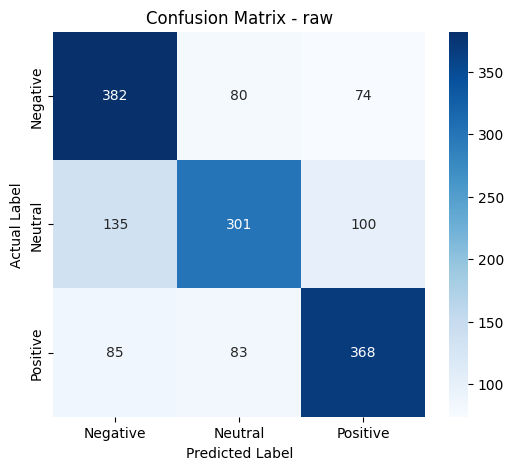



--- Results for DataFrame Type: 'NORMALIZED' ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.71      0.70       536
     Neutral       0.67      0.57      0.61       536
    Positive       0.66      0.73      0.69       536

    accuracy                           0.67      1608
   macro avg       0.67      0.67      0.67      1608
weighted avg       0.67      0.67      0.67      1608

Average Accuracy: 0.6710
Macro F1-Score: 0.6691
--------------------


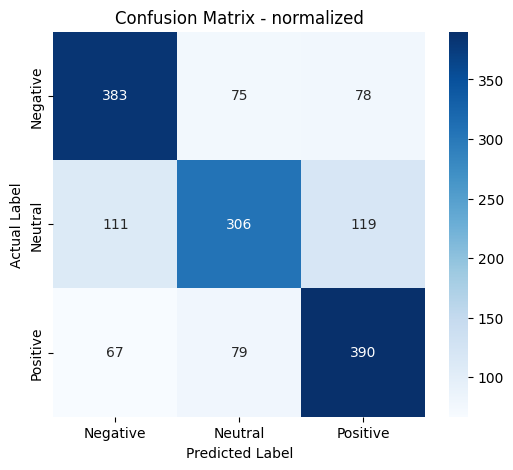



--- Results for DataFrame Type: 'NORMALIZED_AND_NO_STOPWORDS' ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.66      0.67       536
     Neutral       0.61      0.57      0.59       536
    Positive       0.62      0.67      0.64       536

    accuracy                           0.63      1608
   macro avg       0.63      0.63      0.63      1608
weighted avg       0.63      0.63      0.63      1608

Average Accuracy: 0.6337
Macro F1-Score: 0.6332
--------------------


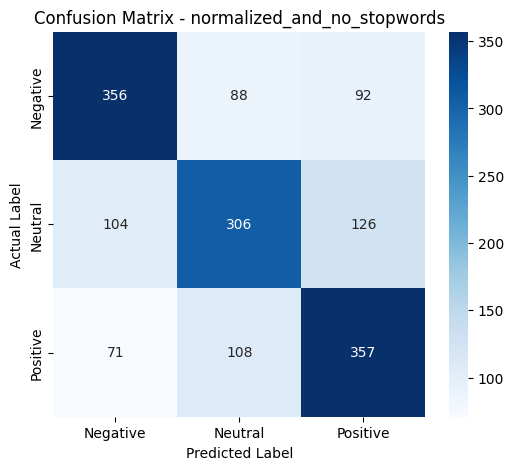



--- Results for DataFrame Type: 'FULL_PREPROCESSED' ---
Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.65      0.65       536
     Neutral       0.61      0.55      0.58       536
    Positive       0.61      0.66      0.63       536

    accuracy                           0.62      1608
   macro avg       0.62      0.62      0.62      1608
weighted avg       0.62      0.62      0.62      1608

Average Accuracy: 0.6194
Macro F1-Score: 0.6185
--------------------


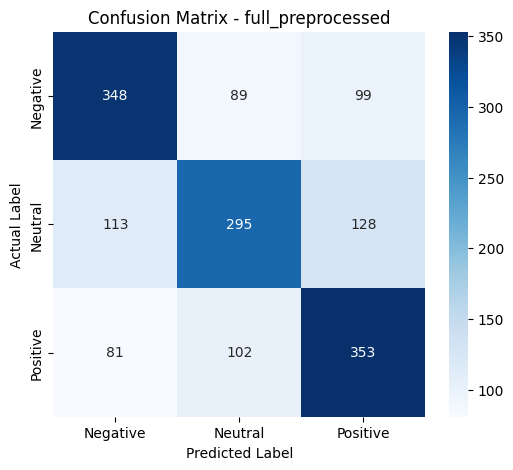

In [11]:
# Loop through each preprocessed split
for name, data_split in splits.items():
    print(f"{'='*60}")
    print(f"--- Results for DataFrame Type: '{name.upper()}' ---")
    print(f"{'='*60}")

    # Extract data
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    y_test = data_split['y_test']

    # Vectorize the text data using TF-IDF
    # We fit the vectorizer ONLY on the training data
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test) # Use the same vectorizer to transform the test data

    # Initialize and train the MultinomialNB model
    model = MultinomialNB()
    model.fit(X_train_tfidf, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_tfidf)

    # Report the metrics
    # The classification_report provides precision, recall, f1-score per class, and macro/weighted averages.
    report = classification_report(y_test, y_pred, zero_division=0)
    print("Classification Report:")
    print(report)

    # Extract and print the specific requested metrics
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    macro_f1 = report_dict['macro avg']['f1-score']

    print(f"Average Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1:.4f}")
    print("-" * 20)

    # Plot the Confusion Matrix
    class_labels = model.classes_
    plot_confusion_matrix(y_test, y_pred, classes=class_labels, title=name)

    print("\n")
